In [2]:
import os
import json
import gc
from collections import defaultdict

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from loguru import logger
from sklearn.cluster import DBSCAN

REPLAYS_DIR = os.path.join('../replays/')

In [3]:
def file_size_mb(path):
    size = os.path.getsize(path)
    result = round(size / (1024 * 1024))
    return result

In [4]:
files = [file for file in os.listdir(REPLAYS_DIR) if '.jsonlines' in file]
print(len(files))
sum(file_size_mb(os.path.join(REPLAYS_DIR, file)) for file in files)

54


1977

2GB данных - уже лучше, чем один матч, при этом все еще влезают в оперативную память

In [5]:
limit = 10
logger.info('Reading files...')

partitions = []
i_file = 0
for file in tqdm(files):
    match_id = file.replace('.jsonlines', '')
    match_id = int(match_id)
    path = os.path.join(REPLAYS_DIR, file)
    with open(path, 'r') as fin:
        events = []
        for line in fin:
            event = json.loads(line)
            event['match_id'] = match_id
            events.append(event)
        df_partition = pd.DataFrame(events)
        partitions.append(df_partition)
        del events
        gc.collect()
    if i_file == limit:
        break
    i_file += 1

logger.info('Conacating files...')
df = pd.concat(partitions)
df.reset_index(drop=True, inplace=True)
del partitions
gc.collect()

2022-07-04 15:37:46.056 | INFO     | __main__:<cell line: 2>:2 - Reading files...
 19%|█████████████████▏                                                                           | 10/54 [00:30<02:13,  3.04s/it]
2022-07-04 15:38:16.494 | INFO     | __main__:<cell line: 24>:24 - Conacating files...


0

На хранение данных в pandas нам потребуется около 10 GB оперативной памяти

In [6]:
df.shape

(2379130, 60)

In [11]:
df.columns

Index(['time', 'type', 'value', 'attackername', 'targetname', 'sourcename',
       'targetsourcename', 'attackerhero', 'targethero', 'attackerillusion',
       'targetillusion', 'inflictor', 'match_id', 'key', 'slot', 'gold', 'lh',
       'xp', 'stuns', 'level', 'kills', 'deaths', 'assists', 'denies',
       'obs_placed', 'sen_placed', 'creeps_stacked', 'camps_stacked',
       'rune_pickups', 'randomed', 'pred_vict', 'firstblood_claimed',
       'teamfight_participation', 'towers_killed', 'roshans_killed',
       'observers_placed', 'hero_id', 'draft_order', 'pick',
       'draft_active_team', 'draft_extime0', 'draft_extime1', 'player1',
       'player2', 'gold_reason', 'valuename', 'abilitylevel', 'charges',
       'unit', 'x', 'y', 'life_state', 'z', 'entityleft', 'ehandle',
       'xp_reason', 'itemslot', 'stun_duration', 'slow_duration',
       'secondary_charges'],
      dtype='object')

In [12]:
df[['type', 'match_id']].groupby('match_id').count()

,type
match_id,
6058993154,164566
6070412895,200055
6079386505,161236
6080247712,259681
6212734584,238183
6212985654,193464
6215020578,254282
6216545156,236060
6223446359,175532


In [13]:
pd.options.display.max_rows = 65
display(
    df[['time', 'type']]
    .groupby('type')
    .count()
    .sort_values(['time'], ascending=False)
)

,time
type,
actions,1270633
interval,376280
DOTA_COMBATLOG_DAMAGE,260005
DOTA_COMBATLOG_MODIFIER_ADD,110876
DOTA_COMBATLOG_MODIFIER_REMOVE,109852
DOTA_COMBATLOG_XP,54162
DOTA_COMBATLOG_DEATH,43370
DOTA_COMBATLOG_ABILITY,35347
DOTA_COMBATLOG_HEAL,35220


# Name and Slot
Выход парсера -- типичный пример, как делать не надо. У событий нет единого идентификатора игрока

При этом, например, для `interval` событий `attackername` всегда NaN. Но зато там есть `slot` и `hero_id`

In [14]:
df[df['type'] == 'interval'].sample(10)

,time,type,value,attackername,targetname,sourcename,targetsourcename,attackerhero,targethero,attackerillusion,...,y,life_state,z,entityleft,ehandle,xp_reason,itemslot,stun_duration,slow_duration,secondary_charges
1931934,-365,interval,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50219,437,interval,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,136.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
652129,-410,interval,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1860944,1029,interval,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,148.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
648578,-764,interval,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
432847,-563,interval,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1403082,346,interval,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,150.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1368939,-482,interval,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
928560,728,interval,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,118.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1697014,1277,interval,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,108.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df[pd.notnull(df['player2']) & (df['player2'] >= 0)]

,time,type,value,attackername,targetname,sourcename,targetsourcename,attackerhero,targethero,attackerillusion,...,y,life_state,z,entityleft,ehandle,xp_reason,itemslot,stun_duration,slow_duration,secondary_charges
34924,259,CHAT_MESSAGE_HERO_KILL,330.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34925,259,CHAT_MESSAGE_FIRSTBLOOD,330.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42452,347,CHAT_MESSAGE_HERO_KILL,202.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47825,408,CHAT_MESSAGE_HERO_KILL,181.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56100,502,CHAT_MESSAGE_COURIER_LOST,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2377506,3198,CHAT_MESSAGE_HERO_KILL,388.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2377572,3198,CHAT_MESSAGE_HERO_KILL,346.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2377573,3198,CHAT_MESSAGE_STREAK_KILL,346.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2378195,3203,CHAT_MESSAGE_HERO_KILL,492.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df[pd.notnull(df['player2']) & (df['player2'] >= 0)]['type'].unique()

array(['CHAT_MESSAGE_HERO_KILL', 'CHAT_MESSAGE_FIRSTBLOOD',
       'CHAT_MESSAGE_COURIER_LOST', 'CHAT_MESSAGE_STREAK_KILL',
       'CHAT_MESSAGE_ROSHAN_KILL', 'CHAT_MESSAGE_EFFIGY_KILL'],
      dtype=object)

Скачаем словарь с описанием персонажей и связью `hero_id`, `hero_name`

In [17]:
r = requests.get('https://raw.githubusercontent.com/odota/dotaconstants/master/build/hero_names.json')
r.raise_for_status()
heroes = r.json()

Пасхалка для олдов. В файлах игры Shadow Fiend называется Nevermore.

In [18]:
heroes['npc_dota_hero_nevermore']

{'id': 11,
 'name': 'npc_dota_hero_nevermore',
 'localized_name': 'Shadow Fiend',
 'primary_attr': 'agi',
 'attack_type': 'Ranged',
 'roles': ['Carry', 'Nuker'],
 'img': '/apps/dota2/images/dota_react/heroes/nevermore.png?',
 'icon': '/apps/dota2/images/dota_react/heroes/icons/nevermore.png?',
 'base_health': 200,
 'base_health_regen': 0.25,
 'base_mana': 75,
 'base_mana_regen': 0.3,
 'base_armor': 1,
 'base_mr': 25,
 'base_attack_min': 19,
 'base_attack_max': 25,
 'base_str': 19,
 'base_agi': 20,
 'base_int': 18,
 'str_gain': 2.7,
 'agi_gain': 3.5,
 'int_gain': 2.2,
 'attack_range': 500,
 'projectile_speed': 1200,
 'attack_rate': 1.6,
 'move_speed': 305,
 'turn_rate': 0.9,
 'cm_enabled': True,
 'legs': 0}

In [19]:
hero_id_to_name = {int(dct['id']): name for name, dct in heroes.items()}
hero_id_to_name

{1: 'npc_dota_hero_antimage',
 2: 'npc_dota_hero_axe',
 3: 'npc_dota_hero_bane',
 4: 'npc_dota_hero_bloodseeker',
 5: 'npc_dota_hero_crystal_maiden',
 6: 'npc_dota_hero_drow_ranger',
 7: 'npc_dota_hero_earthshaker',
 8: 'npc_dota_hero_juggernaut',
 9: 'npc_dota_hero_mirana',
 10: 'npc_dota_hero_morphling',
 11: 'npc_dota_hero_nevermore',
 12: 'npc_dota_hero_phantom_lancer',
 13: 'npc_dota_hero_puck',
 14: 'npc_dota_hero_pudge',
 15: 'npc_dota_hero_razor',
 16: 'npc_dota_hero_sand_king',
 17: 'npc_dota_hero_storm_spirit',
 18: 'npc_dota_hero_sven',
 19: 'npc_dota_hero_tiny',
 20: 'npc_dota_hero_vengefulspirit',
 21: 'npc_dota_hero_windrunner',
 22: 'npc_dota_hero_zuus',
 23: 'npc_dota_hero_kunkka',
 25: 'npc_dota_hero_lina',
 26: 'npc_dota_hero_lion',
 27: 'npc_dota_hero_shadow_shaman',
 28: 'npc_dota_hero_slardar',
 29: 'npc_dota_hero_tidehunter',
 30: 'npc_dota_hero_witch_doctor',
 31: 'npc_dota_hero_lich',
 32: 'npc_dota_hero_riki',
 33: 'npc_dota_hero_enigma',
 34: 'npc_dota_hero_ti

Обратим внимание, что hero_id есть в interval и draft_timings событиях

In [20]:
df[pd.notnull(df['hero_id'])]['type'].unique()

array(['draft_timings', 'interval'], dtype=object)

Создадим новый столбец hero_name на основе hero_id

In [21]:
df['hero_name'] = df['hero_id'].fillna(-1).apply(
    lambda hero_id: hero_id_to_name.get(int(hero_id), np.nan)
)

Всего персонажей

In [22]:
df['hero_name'].nunique()

77

In [23]:
df_interval = df[(df['type'] == 'interval') & pd.notnull(df['hero_id'])]
df_name_slot = (
    df_interval
    [['match_id', 'hero_name', 'slot']]
    .drop_duplicates()
    .sort_values(['match_id', 'slot'])
)
df_name_slot['slot'] = df_name_slot['slot'].astype(np.int8)

In [24]:
df_name_slot

,match_id,hero_name,slot
1768616,6058993154,npc_dota_hero_viper,0
1768640,6058993154,npc_dota_hero_mars,1
1768666,6058993154,npc_dota_hero_kunkka,2
1768691,6058993154,npc_dota_hero_mirana,3
1768715,6058993154,npc_dota_hero_sven,4
...,...,...,...
855789,6227305557,npc_dota_hero_spectre,5
855815,6227305557,npc_dota_hero_tinker,6
855840,6227305557,npc_dota_hero_bloodseeker,7
855871,6227305557,npc_dota_hero_rubick,8


In [25]:
match_name_slot = defaultdict(dict)
for _, row in df_name_slot.iterrows():
    match_data = match_name_slot[row['match_id']]
    match_data[row['hero_name']] = row['slot']

In [26]:
match_name_slot[6058993154]

{'npc_dota_hero_viper': 0,
 'npc_dota_hero_mars': 1,
 'npc_dota_hero_kunkka': 2,
 'npc_dota_hero_mirana': 3,
 'npc_dota_hero_sven': 4,
 'npc_dota_hero_hoodwink': 5,
 'npc_dota_hero_winter_wyvern': 6,
 'npc_dota_hero_void_spirit': 7,
 'npc_dota_hero_gyrocopter': 8,
 'npc_dota_hero_tidehunter': 9}

# TODO Join df and df_name_slot

In [27]:
df['attackerslot'] = np.nan

In [28]:
(
    df
    [['type', 'attackerslot']]
    .groupby('type')
    .agg({'attackerslot': lambda x: x.isnull().sum()})
    .sort_values(['attackerslot'], ascending=False)
)

,attackerslot
type,
actions,1270633
interval,376280
DOTA_COMBATLOG_DAMAGE,260005
DOTA_COMBATLOG_MODIFIER_ADD,110876
DOTA_COMBATLOG_MODIFIER_REMOVE,109852
DOTA_COMBATLOG_XP,54162
DOTA_COMBATLOG_DEATH,43370
DOTA_COMBATLOG_ABILITY,35347
DOTA_COMBATLOG_HEAL,35220


In [29]:
df_attackerslot = pd.merge(
    left=df[['match_id', 'attackername']], 
    right=df_name_slot, 
    how='left', 
    left_on=['match_id', 'attackername'],
    right_on=['match_id', 'hero_name'],
)
df['attackerslot'] = df_attackerslot['slot']

interval_idx = df[df['type'] == 'interval'].index
df.loc[interval_idx, 'attackerslot'] = df.loc[interval_idx, 'slot']

In [30]:
(
    df
    [['type', 'attackerslot']]
    .groupby('type')
    .agg({'attackerslot': lambda x: x.isnull().sum()})
    .sort_values(['attackerslot'], ascending=False)
)

,attackerslot
type,
actions,1270633
DOTA_COMBATLOG_DAMAGE,84682
DOTA_COMBATLOG_XP,54162
DOTA_COMBATLOG_GOLD,32157
DOTA_COMBATLOG_DEATH,17282
DOTA_COMBATLOG_HEAL,11013
DOTA_COMBATLOG_MODIFIER_ADD,7758
DOTA_COMBATLOG_MODIFIER_REMOVE,7731
DOTA_COMBATLOG_PURCHASE,6564


In [31]:
(
    df
    .query('type == "DOTA_COMBATLOG_DAMAGE" and attackername == "npc_dota_hero_lycan"')
    [['unit', 'slot', 'attackerslot']]
)

,unit,slot,attackerslot


In [32]:
(
    df
    .query('type == "interval" and unit == "CDOTA_Unit_Hero_AncientApparition"')
    [['unit', 'slot', 'attackerslot']]
)

,unit,slot,attackerslot
655707,CDOTA_Unit_Hero_AncientApparition,8.0,8.0
655780,CDOTA_Unit_Hero_AncientApparition,8.0,8.0
655836,CDOTA_Unit_Hero_AncientApparition,8.0,8.0
655883,CDOTA_Unit_Hero_AncientApparition,8.0,8.0
655927,CDOTA_Unit_Hero_AncientApparition,8.0,8.0
...,...,...,...
846501,CDOTA_Unit_Hero_AncientApparition,8.0,8.0
846574,CDOTA_Unit_Hero_AncientApparition,8.0,8.0
846628,CDOTA_Unit_Hero_AncientApparition,8.0,8.0
846735,CDOTA_Unit_Hero_AncientApparition,8.0,8.0


In [79]:
# df_targetslot = pd.merge(
#     left=df[['match_id', 'targetname']], 
#     right=df_name_slot, 
#     how='inner', 
#     left_on=['match_id', 'targetname'],
#     right_on=['match_id', 'hero_name'],
# )
# df['targetslot'] = df_targetslot['slot']
# del df_targetslot

In [133]:
# df[['match_id', 'attackername']].apply((
#     lambda row: match_name_slot[row['match_id']].get(row['attackername'], np.nan)
# ), axis=1)

In [2]:
# df['attackerslot'] = np.nan
# df['targetslot'] = np.nan

In [45]:
# df['attackerslot'] = df['slot']

# with tqdm(total=df.shape[0]) as pbar:
#     for i, row in df.iterrows():
#         match_id = row['match_id']
        
#         attackername = row['attackername']
#         attackerslot = match_name_slot[match_id].get(attackername, np.nan)
#         df.loc[i, 'attackerslot'] = attackerslot
        
#         sourcename = row['sourcename']
#         sourceslot = match_name_slot[match_id].get(sourcename, attackerslot)
#         df.loc[i, 'sourceslot'] = sourceslot
        
#         targetname = row['targetname']
#         targetslot = match_name_slot[match_id].get(attackername, np.nan)
#         df.loc[i, 'targetslot'] = targetslot
#         pbar.update(1)

# Clustering

In [33]:
def dota_clock_format(seconds):
    minutes = str(seconds // 60).zfill(2)
    secs = str(seconds % 60).zfill(2)
    return f'{minutes}:{secs}'

In [34]:
df['clock'] = df['time'].apply(dota_clock_format)
df['ones'] = 1
df['cluster_10'] = np.nan
df['cluster_20'] = np.nan
df['cluster_30'] = np.nan

In [35]:
df_damage = df[
    (df['type'] == 'DOTA_COMBATLOG_DAMAGE') &
    (df['time'] > 10 * 60) &
    (df['attackerhero'] & df['targethero'])
]

In [36]:
iterator = df_damage.groupby(['match_id', 'attackerslot'])

with tqdm(total=len(iterator)) as pbar:
    for (match_id, hero_name), df_hero_damage in iterator:
        for eps in (10, 20, 30):
            dbscan = DBSCAN(eps=eps, min_samples=5)
            cluster = dbscan.fit_predict(df_hero_damage[['time', 'ones']])
            df.loc[df_hero_damage.index, f'cluster_{eps}'] = cluster
        pbar.update(1)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:00<00:00, 144.70it/s]


Fill NaNs for attacker

In [37]:
iterator = df.groupby(['match_id', 'attackerslot', 'cluster_30'])

with tqdm(total=len(iterator)) as pbar:
    for (match_id, attackerslot, cluster_30), df_events in iterator:
        start_time = df_events['time'].min()
        end_time = df_events['time'].max()

        idx = df[(
            (df['match_id'] == match_id) &
            (df['attackerslot'] == attackerslot) &
            (df['time'] >= start_time) & (df['time'] <= end_time)
        )].index
        df.loc[idx, 'cluster_30'] = cluster_30
        pbar.update(1)

 90%|███████████████████████████████████████████████████████████████████████████████▎        | 1106/1227 [00:10<00:01, 101.82it/s]


# Highlights

In [222]:
(
    df.groupby(['match_id', 'attackerslot', 'cluster_30'])
    .agg({'clock': ['first', 'last'], 'time': ['first', 'last']})
    .sort_values(['match_id', 'attackerslot', ('clock', 'first')])
).head(30)

clock         time      
                                    first   last first  last
match_id   attackerslot cluster_30                          
6058993154 0.0           0.0        10:06  10:10   606   610
                         1.0        11:35  12:01   695   721
                         2.0        12:38  12:50   758   770
                         3.0        13:27  13:38   807   818
                         4.0        14:24  14:45   864   885
                         5.0        16:34  17:19   994  1039
                         6.0        19:12  19:15  1152  1155
                         7.0        20:48  21:02  1248  1262
                         8.0        21:43  23:08  1303  1388
                         9.0        24:07  24:38  1447  1478
                         10.0       25:09  25:13  1509  1513
                         11.0       28:35  28:47  1715  1727
                         12.0       29:53  30:28  1793  1828
           1.0           0.0        12:49  12:59   769   779
                         1.0        14:20  14:32   860   872
                         2.0        16:30  16:58   990  1018
                         3.0        19:05  19:12  1145  1152
                         4.0        20:45  21:01  1245  1261
                         5.0        21:48  22:04  1308  1324
                         6.0        22:54  23:09  1374  1389
                         7.0        24:03  24:44  1443  1484
                        -1.0        28:35  28:35  1715  1715
                         8.0        29:58  30:28  1798  1828
           2.0           0.0        10:02  10:27   602   627
                        -1.0        11:22  11:27   682   687
                         1.0        12:48  12:58   768   778
                         2.0        14:36  15:01   876   901
                         3.0        16:16  17:30   976  1050
                         4.0        19:12  19:32  1152  1172
                         5.0        20:49  22:01  1249  1321

In [223]:
(
    df.groupby(['match_id', 'attackerslot', 'cluster_30', 'type'])
    .agg({
        'time': 'count',
    })
    .sort_values(['match_id', 'attackerslot', 'cluster_30'])
    # .sort_values('time', ascending=False)
).head(30)

time
match_id   attackerslot cluster_30 type                                
6058993154 0.0          0.0        DOTA_COMBATLOG_DAMAGE             17
                                   DOTA_COMBATLOG_DEATH               1
                                   DOTA_COMBATLOG_MODIFIER_ADD        1
                                   DOTA_COMBATLOG_MODIFIER_REMOVE     3
                                   DOTA_COMBATLOG_PLAYERSTATS         4
                                   interval                           5
                        1.0        DOTA_COMBATLOG_ABILITY             1
                                   DOTA_COMBATLOG_DAMAGE             16
                                   DOTA_COMBATLOG_ITEM                1
                                   DOTA_COMBATLOG_MODIFIER_ADD        3
                                   DOTA_COMBATLOG_MODIFIER_REMOVE     5
                                   DOTA_COMBATLOG_PLAYERSTATS         3
                                   interval                          27
                        2.0        DOTA_COMBATLOG_ABILITY             2
                                   DOTA_COMBATLOG_DAMAGE             65
                                   DOTA_COMBATLOG_DEATH               1
                                   DOTA_COMBATLOG_HEAL                1
                                   DOTA_COMBATLOG_ITEM                1
                                   DOTA_COMBATLOG_MODIFIER_ADD       10
                                   DOTA_COMBATLOG_MODIFIER_REMOVE    10
                                   DOTA_COMBATLOG_PLAYERSTATS         2
                                   interval                          13
                                   obs_left                           1
                        3.0        DOTA_COMBATLOG_ABILITY             1
                                   DOTA_COMBATLOG_DAMAGE             52
                                   DOTA_COMBATLOG_MODIFIER_ADD       11
                                   DOTA_COMBATLOG_MODIFIER_REMOVE    11
                                   DOTA_COMBATLOG_PLAYERSTATS         2
                                   interval                          12
                        4.0        DOTA_COMBATLOG_ABILITY             1

time                  duration
             first         last             
count  1106.000000  1106.000000  1106.000000
mean   1550.655515  1692.646474   141.990958
std     676.343369   678.044889   419.524331
min     601.000000   606.000000     0.000000
25%     955.500000  1116.000000     7.000000
50%    1452.000000  1656.500000    19.000000
75%    2041.750000  2186.750000    40.000000
max    3196.000000  3207.000000  2413.000000

<AxesSubplot:>

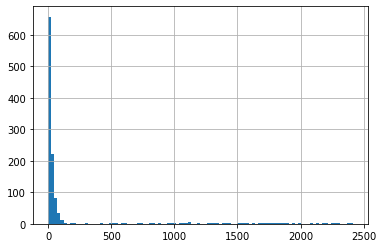

In [243]:
df_duration = (
    df
    .groupby(['match_id', 'attackerslot', 'cluster_30'])
    .agg({
        'time': ['first', 'last']
    })
)
df_duration['duration'] = df_duration[('time', 'last')] - df_duration[('time', 'first')]
display(df_duration.describe())
df_duration['duration'].hist(bins=100)

In [225]:
df[(
    (df['match_id'] == 6058993154) &
    (df['attackerslot'] == 1) &
    (df['cluster_30'] == 8) &
    # (df['type'] == 'DOTA_COMBATLOG_ABILITY') &
    True
)].groupby('type').count()

,time,value,attackername,targetname,sourcename,targetsourcename,attackerhero,targethero,attackerillusion,targetillusion,...,stun_duration,slow_duration,secondary_charges,hero_name,attackerslot,clock,ones,cluster_10,cluster_20,cluster_30
type,,,,,,,,,,,,,,,,,,,,,
DOTA_COMBATLOG_ABILITY,9,9,9,9,9,9,9,9,9,9,...,0,0,0,0,9,9,9,0,0,9
DOTA_COMBATLOG_DAMAGE,17,17,17,17,17,17,17,17,17,17,...,0,0,0,0,17,17,17,17,17,17
DOTA_COMBATLOG_DEATH,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,1,1,0,0,1
DOTA_COMBATLOG_HEAL,38,38,38,38,38,38,38,38,38,38,...,0,0,0,0,38,38,38,0,0,38
DOTA_COMBATLOG_ITEM,7,7,7,7,7,7,7,7,7,7,...,0,0,0,0,7,7,7,0,0,7
DOTA_COMBATLOG_MODIFIER_ADD,31,31,31,31,31,31,31,31,31,31,...,1,1,0,0,31,31,31,0,0,31
DOTA_COMBATLOG_MODIFIER_REMOVE,27,27,27,27,27,27,27,27,27,27,...,2,1,0,0,27,27,27,0,0,27
DOTA_COMBATLOG_PLAYERSTATS,5,5,5,5,5,5,5,5,5,5,...,5,5,0,0,5,5,5,0,0,5
interval,31,0,0,0,0,0,0,0,0,0,...,0,0,0,31,31,31,31,0,0,31


In [226]:
df[(
    (df['match_id'] == 6058993154) &
    (df['attackerslot'] == 1) &
    (df['cluster_30'] == 1) &
    (df['type'] == 'DOTA_COMBATLOG_ABILITY') &
    True
)].groupby('inflictor').count()

,time,type,value,attackername,targetname,sourcename,targetsourcename,attackerhero,targethero,attackerillusion,...,stun_duration,slow_duration,secondary_charges,hero_name,attackerslot,clock,ones,cluster_10,cluster_20,cluster_30
inflictor,,,,,,,,,,,,,,,,,,,,,
mars_arena_of_blood,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,1,1,0,0,1
mars_gods_rebuke,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,1,1,0,0,1
mars_spear,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,1,1,0,0,1


In [227]:
df[(
    (df['match_id'] == 6058993154) &
    (df['attackerslot'] == 1) &
    (df['cluster_30'] == 4) &
    (df['type'] == 'DOTA_COMBATLOG_DEATH') &
    True
)].count()['time']

2

### Урон в секунду

In [228]:
df_cand = (
    df[
        (df['type'] == 'DOTA_COMBATLOG_DAMAGE') &
        (df['time'] > 10 * 60) &
        (df['attackerhero'] & df['targethero']) &
        (df['cluster_30'] > -1) &
        (df['match_id'] == 6227305557)
    ]
    .groupby(['match_id', 'attackerslot', 'cluster_30'])
    .agg({
        'value': 'sum', 
        'clock': ['first', 'last'],
        'time': ['first', 'last'],
    })
)

df_cand['duration'] = df_cand[('time', 'last')] - df_cand[('time', 'first')]
df_cand['damage_per_time'] = df_cand[('value', 'sum')] / df_cand['duration']

(
    df_cand[(
        (df_cand['duration'] > 5)
        
    )]
    .sort_values('damage_per_time', ascending=False)
    .head(20)
)

value  clock         time        \
                                        sum  first   last first  last   
match_id   attackerslot cluster_30                                      
6227305557 1.0          9.0          7654.0  44:50  44:57  2690  2697   
           2.0          9.0          3274.0  39:46  39:54  2386  2394   
                        12.0         5393.0  48:48  49:02  2928  2942   
           1.0          8.0          5718.0  42:44  42:59  2564  2579   
                        4.0          8153.0  25:56  26:20  1556  1580   
                        5.0          4055.0  27:24  27:37  1644  1657   
           3.0          12.0         4122.0  37:55  38:09  2275  2289   
           6.0          1.0          3773.0  18:11  18:24  1091  1104   
           1.0          10.0        14213.0  48:35  49:30  2915  2970   
           0.0          5.0          6911.0  29:09  29:37  1749  1777   
           6.0          4.0          2424.0  27:30  27:40  1650  1660   
           1.0          7.0          8634.0  32:53  33:30  1973  2010   
           0.0          4.0          5153.0  25:58  26:22  1558  1582   
           2.0          10.0         2250.0  42:42  42:53  2562  2573   
           0.0          7.0          4890.0  42:39  43:03  2559  2583   
           1.0          6.0          4859.0  30:44  31:08  1844  1868   
                        3.0          2858.0  22:50  23:06  1370  1386   
           5.0          14.0         3567.0  37:40  38:00  2260  2280   
                        7.0          1055.0  27:31  27:37  1651  1657   
           6.0          10.0        17150.0  48:23  50:04  2903  3004   

                                   duration damage_per_time  
                                                             
match_id   attackerslot cluster_30                           
6227305557 1.0          9.0               7     1093.428571  
           2.0          9.0               8      409.250000  
                        12.0             14      385.214286  
           1.0          8.0              15      381.200000  
                        4.0              24      339.708333  
                        5.0              13      311.923077  
           3.0          12.0             14      294.428571  
           6.0          1.0              13      290.230769  
           1.0          10.0             55      258.418182  
           0.0          5.0              28      246.821429  
           6.0          4.0              10      242.400000  
           1.0          7.0              37      233.351351  
           0.0          4.0              24      214.708333  
           2.0          10.0             11      204.545455  
           0.0          7.0              24      203.750000  
           1.0          6.0              24      202.458333  
                        3.0              16      178.625000  
           5.0          14.0             20      178.350000  
                        7.0               6      175.833333  
           6.0          10.0            101      169.801980

### Фраги в секунду

In [231]:
df['match_id'].unique()

array([6215020578, 6223446359, 6227203516, 6070412895, 6227305557,
       6212734584, 6216545156, 6079386505, 6058993154, 6212985654,
       6080247712])

In [235]:
df_cand = (
    df[
        (df['type'] == 'DOTA_COMBATLOG_DEATH') &
        (df['time'] > 10 * 60) &
        (df['attackerhero'] & df['targethero']) &
        (df['cluster_30'] > -1) &
        (df['match_id'] == 6227305557)
    ]
    .groupby(['match_id', 'attackerslot', 'cluster_30'])
    .agg({
        'value': 'count', 
        'clock': ['first', 'last'],
        'time': ['first', 'last'],
    })
)

df_cand['duration'] = df_cand[('time', 'last')] - df_cand[('time', 'first')]
df_cand['value_per_time'] = df_cand[('value', 'count')] / df_cand['duration']

# display(df_cand)
(
    df_cand[(
        (df_cand['duration'] > 0)
    )]
    .sort_values('value_per_time', ascending=False)
    .head(20)
)

value  clock         time       duration  \
                                   count  first   last first  last            
match_id   attackerslot cluster_30                                            
6227305557 6.0          10.0           3  49:39  49:42  2979  2982        3   
                        9.0            2  45:25  45:41  2725  2741       16   
           5.0          9.0            2  29:10  29:38  1750  1778       28   
                        4.0            2  20:31  21:00  1231  1260       29   
                        20.0           3  48:44  49:38  2924  2978       54   
                        3.0            2  17:51  18:52  1071  1132       61   

                                   value_per_time  
                                                   
match_id   attackerslot cluster_30                 
6227305557 6.0          10.0             1.000000  
                        9.0              0.125000  
           5.0          9.0              0.071429  
                        4.0              0.068966  
                        20.0             0.055556  
                        3.0              0.032787

- Продолжительность момента
- Урон по хайлайтам
- Использованные способности
- Кол-во целей-героев

Основные выводы:

- Зачастую хайлайт начинается в момент, когда героя уже убили
- В результате работы метода можем получать хайлайты длины 0 секунд